#### Getting background information
Before diving into analyzing the data, it's useful to research some background information. In this case, we know a few facts that will be useful:

* New York City is divided into 5 boroughs, which are essentially distinct regions.
* Schools in New York City are divided into several school district, each of which can contains dozens of schools.
* Not all the schools in all of the datasets are high schools, so we'll need to do some data cleaning.
* Each school in New York City has a unique code called a DBN, or District Borough Number.
* By aggregating data by district, we can use the district mapping data to plot district-by-district differences.

In [1]:
import pandas
import numpy as np

files = ["math_test_results.csv", "ap_2010.csv", "sat_results.csv", "class_size.csv", "demographics.csv", "graduation.csv", "hs_directory.csv"]

data = {}
for f in files:
    d = pandas.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head())


math_test_results

      DBN Grade  Year      Category  Number Tested Mean Scale Score Level 1 #  \
0  01M015     3  2006  All Students             39              667         2   
1  01M015     3  2007  All Students             31              672         2   
2  01M015     3  2008  All Students             37              668         0   
3  01M015     3  2009  All Students             33              668         0   
4  01M015     3  2010  All Students             26              677         6   

  Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 # Level 4 %  \
0      5.1%        11     28.2%        20     51.3%         6     15.4%   
1      6.5%         3      9.7%        22       71%         4     12.9%   
2        0%         6     16.2%        29     78.4%         2      5.4%   
3        0%         4     12.1%        28     84.8%         1        3%   
4     23.1%        12     46.2%         6     23.1%         2      7.7%   

  Level 3+4 # Level 3+4 %  
0          26 

* Most of the datasets contain a DBN column
* Some fields look interesting for mapping, particularly Location 1, which contains coordinates inside a larger string.
* Some of the datasets appear to contain multiple rows for each school (repeated DBN values), which means we'll have to do some preprocessing.

#### Unifying the data
In order to work with the data more easily, we'll need to unify all the individual datasets into a single one. This will enable us to quickly compare columns across datasets. In order to do this, we'll first need to find a common column to unify them on. Looking at the output above, it appears that DBN might be that common column, as it appears in multiple datasets.

If we google DBN New York City Schools, we end up here, which explains that the DBN is a unique code for each school. When exploring datasets, particularly government ones, it's often necessary to do some detective work to figure out what each column means, or even what each dataset is.

The problem now is that two of the datasets, class_size, and hs_directory, don't have a DBN field. In the hs_directory data, it's just named dbn, so we can just rename the column, or copy it over into a new column called DBN. In the class_size data, we'll need to try a different approach.

The DBN column looks like this:


In [2]:
data['demographics']['DBN'].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

In [3]:
# look at the class_size data
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


As you can see above, it looks like the DBN is actually a combination of CSD, BOROUGH, and SCHOOL CODE. For those unfamiliar with New York City, it is composed of 5 boroughs. Each borough is an organizational unit, and is about the same size as a fairly large US City. DBN stands for District Borough Number. It looks like CSD is the District, BOROUGH is the borough, and when combined with the SCHOOL CODE, forms the DBN. There's no systematized way to find insights like this in data, and it requires some exploration and playing around to figure out.

In [4]:
# Now that we know how to construct the DBN, we can add it into the class_size and hs_directory datasets
data["class_size"]["DBN"] = data["class_size"].apply(lambda x: "{0:02d}{1}".format(x["CSD"], x["SCHOOL CODE"]), axis=1)
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

#### Adding in the surveys
One of the most potentially interesting datasets to look at is the dataset on student, parent, and teacher surveys about the quality of schools. These surveys include information about the perceived safety of each school, academic standards, and more. Before we combine our datasets, let's add in the survey data. In real-world data science projects, you'll often come across interesting data when you're midway through your analysis, and will want to incorporate it.

In this case, we'll add the survey data into our data dictionary, and then combine all the datasets afterwards. The survey data consists of 2 files, one for all schools, and one for school district 75. We'll need to write some code to combine them

* Read in the surveys for all schools using the windows-1252 file encoding.
* Read in the surveys for district 75 schools using the windows-1252 file encoding.
* Add a flag that indicates which school district each dataset is for.
* Combine the datasets into one using the concat method on DataFrames

In [ ]:
survey1 = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
survey2 = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey1["d75"] = False
survey2["d75"] = True
survey = pandas.concat([survey1, survey2], axis=0)

In [ ]:
# Once we have the surveys combined, there's an additional complication.
# We want to minimize the number of columns in our combined dataset so we can easily compare columns and 
# figure out correlations. Unfortunately, the survey data has many columns that aren't very useful to us
survey.head()

In [ ]:
# We can resolve this issue by looking at the data dictionary file that we downloaded along with the survey data
survey["DBN"] = survey["dbn"]
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_10", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11",]
survey = survey.loc[:,survey_fields]
data["survey"] = survey
survey.shape
# Making sure you understand what each dataset contains, and 
# what the relevant columns are can save you lots of time and effort later on.

### Condensing datasets

In [5]:
data["class_size"].head()
# The Problem
# There are several rows for each high school (as you can see by the repeated DBN and SCHOOL NAME fields)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01M015


In [6]:
# However, if we take a look at the sat_results dataset, it only has one row per high school
data["sat_results"].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In order to combine these datasets, we'll need to find a way to condense datasets like class_size to the point where there's only a single row per high school. If not, there won't be a way to compare SAT scores to class size. We can accomplish this by first understanding the data better, then by doing some aggregation. With the class_size dataset, it looks like GRADE and PROGRAM TYPE have multiple values for each school. By restricting each field to a single value, we can filter most of the duplicate rows. In the below code, we:

* Only select values from class_size where the GRADE field is 09-12.
* Only select values from class_size where the PROGRAM TYPE field is GEN ED.
* Group the class_size dataset by DBN, and take the average of each column. Essentially, we'll find the average class_size values for each school.
* Reset the index, so DBN is added back in as a column.

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

#### Condensing other datasets
Next, we'll need to condense the **demographics dataset**. The data was collected for multiple years for the same schools, so there are duplicate rows for each school. We'll only pick rows where the schoolyear field is the most **recent available**

In [8]:
demographics = data["demographics"]
demographics = demographics[demographics["schoolyear"] == 20112012]
data["demographics"] = demographics

In [9]:
# We'll need to condense the math_test_results dataset. This dataset is segmented by Grade and by Year. 
# We can select only a single grade from a single year
data["math_test_results"] = data["math_test_results"][data["math_test_results"]["Year"] == 2011]
data["math_test_results"] = data["math_test_results"][data["math_test_results"]["Grade"] == '8']

In [10]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
# Data cleaning and exploration is critical before working on the meat of the project. Having a good, consistent dataset will help you do your analysis more quickly

### Computing variables
Computing variables can help speed up our analysis by enabling us to make comparisons more quickly, and enable us to make comparisons that we otherwise wouldn't be able to do. The first thing we can do is compute a total SAT score from the individual columns **SAT Math Avg. Score, SAT Critical Reading Avg. Score, and SAT Writing Avg. Score**
* Convert each of the SAT score columns from a string to a number.
* Add together all of the columns to get the sat_score column, which is the total SAT score.

In [11]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    # there are strings such as 's' in col, need to use coerce
    # df[pd.to_numeric(df.col, errors='coerce').isnull()
    data["sat_results"][c]=pandas.to_numeric(data["sat_results"][c], errors='coerce')
    

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

#### Next, we'll need to parse out the coordinate locations of each school, so we can make maps. This will enable us to plot the location of each school. In the below code, we:

* Parse latitude and longitude columns from the Location 1 column.
* Convert lat and lon to be numeric.

In [12]:
data["hs_directory"]['lat'] = data["hs_directory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[0])
data["hs_directory"]['lon'] = data["hs_directory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[1])

for c in ['lat', 'lon']:
    data["hs_directory"][c] = pandas.to_numeric(data["hs_directory"][c])

In [13]:
for k,v in data.items():
    print(k)
    print(v.head())

math_test_results
        DBN Grade  Year      Category  Number Tested Mean Scale Score  \
111  01M034     8  2011  All Students             48              646   
280  01M140     8  2011  All Students             61              665   
346  01M184     8  2011  All Students             49              727   
388  01M188     8  2011  All Students             49              658   
411  01M292     8  2011  All Students             49              650   

    Level 1 # Level 1 % Level 2 # Level 2 % Level 3 # Level 3 % Level 4 #  \
111        15     31.3%        22     45.8%        11     22.9%         0   
280         1      1.6%        43     70.5%        17     27.9%         0   
346         0        0%         0        0%         5     10.2%        44   
388        10     20.4%        26     53.1%        10     20.4%         3   
411        15     30.6%        25       51%         7     14.3%         2   

    Level 4 % Level 3+4 # Level 3+4 %  
111        0%          11       22.9%  


#### Combining the datasets
Now that we've done all the preliminaries, we can combine the datasets together using the **DBN column**. At the end, we'll have a dataset with hundreds of columns, from each of the original datasets. When we join them, it's important to note that some of the datasets are **missing high schools that exist in the sat_results dataset**. To resolve this, we'll need to merge the datasets that have missing rows using the **outer join** strategy, so we don't lose data. In real-world data analysis, it's common to have data be missing. **Being able to demonstrate the ability to reason about and handle missing data is an important part of building a portfolio**

In below:
* Loop through each of the items in the data dictionary.
* Print the number of non-unique DBNs in the item.
* Decide on a join strategy -- inner or outer.
* Join the item to the DataFrame full using the column DBN.

In [14]:
flat_data_names = [k for k,v in data.items()]
flat_data = [data[k] for k in flat_data_names]
full = flat_data[0]
for i, f in enumerate(flat_data[1:]):
    name = flat_data_names[i+1]
    print(name)
    print(len(f["DBN"]) - len(f["DBN"].unique()))
    join_type = "inner"
    if name in ["sat_results", "ap_2010", "graduation"]:
        join_type = "outer"
    if name not in ["math_test_results"]:
        full = full.merge(f, on="DBN", how=join_type)

full.shape

ap_2010
1
sat_results
0
class_size
0
demographics
0
graduation
0
hs_directory
0


(374, 158)

### Need to fill in survey data

### Adding in values
Now that we have our full DataFrame, we have almost all the information we'll need to do our analysis. There are a few missing pieces, though. We may want to correlate the Advanced Placement exam results with SAT scores, but we'll need to first convert those columns to numbers, then fill in any missing values:

In [15]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    full[col] = pandas.to_numeric(full[col], errors='coerce')
full[cols] = full[cols].fillna(value=0)

Then, we'll need to calculate a school_dist column that indicates the school district of the school. This will enable us to match up school districts and plot out district-level statistics using the district maps we downloaded earlier:

In [16]:
full["school_dist"] = full["DBN"].apply(lambda x: x[:2])
#Finally, we'll need to fill in any missing values in full with the mean of the column, so we can compute correlations:
full = full.fillna(full.mean())

### Computing correlations
A good way to explore a dataset and see what columns are related to the one you care about is to compute correlations. This will tell you which columns are closely related to the column you're interested in. We can do this via the corr method on Pandas DataFrames. The closer to 0 the correlation, the weaker the connection. The closer to 1, the stronger the positive correlation, and the closer to -1, the stronger the negative correlation:

In [17]:
full.corr()['sat_score']

Year                                             NaN
Number Tested                           8.127817e-02
AP Test Takers                          5.687940e-01
Total Exams Taken                       5.585421e-01
Number of Exams with scores 3 4 or 5    5.619043e-01
SAT Critical Reading Avg. Score         9.868201e-01
SAT Math Avg. Score                     9.726430e-01
SAT Writing Avg. Score                  9.877708e-01
sat_score                               1.000000e+00
CSD                                     4.274064e-02
NUMBER OF STUDENTS / SEATS FILLED       3.893165e-01
NUMBER OF SECTIONS                      3.556337e-01
AVERAGE CLASS SIZE                      3.731897e-01
SIZE OF SMALLEST CLASS                  2.440690e-01
SIZE OF LARGEST CLASS                   3.052551e-01
SCHOOLWIDE PUPIL-TEACHER RATIO                   NaN
schoolyear                                       NaN
frl_percent                            -7.018217e-01
total_enrollment                        3.6682

### This gives us quite a few insights that we'll need to explore:

* Total enrollment correlates strongly with sat_score, which is surprising, because you'd think smaller schools, which focused more on the student, would have higher scores.
* The percentage of females at a school (female_per) correlates positively with SAT score, whereas the percentage of males (male_per) correlates negatively.
* None of the survey responses correlate highly with SAT scores.
* There is a significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
* ell_percent correlates strongly negatively with SAT scores

#### Exploring enrollment and SAT scores
move into exploring the angles we identified earlier, when we were finding correlations. The first angle to explore is the relationship between the number of students enrolled in a school and SAT scor

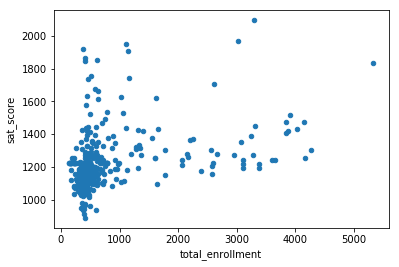

In [24]:
#  total enrollment across all schools to SAT scores across all schools
%matplotlib inline

full.plot.scatter(x='total_enrollment', y='sat_score')

there's a cluster at the bottom left with low total enrollment and low SAT scores. Other than this cluster, there appears to only be a slight positive correlation between SAT scores and total enrollment. Graphing out correlations can reveal unexpected patterns.

In [ ]:
full[(full["total_enrollment"] < 1000) & (full["sat_score"] < 1000)]["School Name"]
# Some searching on Google shows that most of these schools are for students who are learning English,
# and are low enrollment as a result. This exploration showed us that it's not total enrollment that's correlated to 
# SAT score -- it's whether or not students in the school are learning English as a second language or not.

#### Exploring English language learners and SAT scores
Now that we know the percentage of English language learners in a school is correlated with lower SAT scores, we can explore the relationship. The ell_percent column is the percentage of students in each school who are learning English. We can make a scatterplot of this relationship:

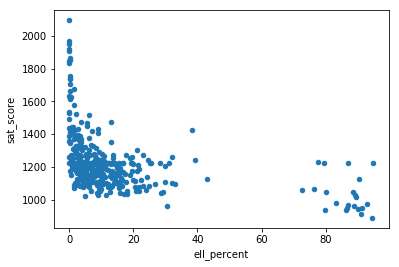

In [25]:
full.plot.scatter(x='ell_percent', y='sat_score')

#### Correlating survey scores and SAT scores
It would be fair to assume that the results of student, parent, and teacher surveys would have a large correlation with SAT scores. It makes sense that schools with high academic expectations, for instance, would tend to have higher SAT scores. To test this theory, lets plot out SAT scores and the various survey metrics

In [ ]:
full.corr()["sat_score"][["rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_tot_11", "com_tot_11", "aca_tot_11", "eng_tot_11"]].plot.bar()

Surprisingly, the two factors that correlate the most are N_p and N_s, which are the counts of parents and students who responded to the surveys. Both strongly correlate with total enrollment, so are likely biased by the ell_learners. The other metric that correlates most is saf_t_11. That is how safe students, parents, and teachers perceived the school to be. It makes sense that the safer the school, the more comfortable students feel learning in the environment. However, none of the other factors, like engagement, communication, and academic expectations, correlated with SAT scores. This may indicate that NYC is asking the wrong questions in surveys, or thinking about the wrong factors (if their goal is to improve SAT scores, it may not be).

#### Exploring race and SAT scores
One of the other angles to investigate involves race and SAT scores. There was a large correlation differential, and plotting it out will help us understand what's happening:

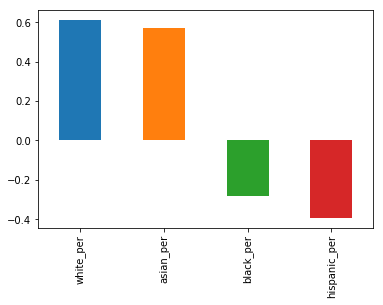

In [26]:
full.corr()["sat_score"][["white_per", "asian_per", "black_per", "hispanic_per"]].plot.bar()

It looks like the higher percentages of white and asian students correlate with higher SAT scores, but higher percentages of black and hispanic students correlate with lower SAT scores. For hispanic students, this may be due to the fact that there are more recent immigrants who are ELL learners

#### Gender differences in SAT scores
The final angle to explore is the relationship between gender and SAT score. We noted that a higher percentage of females in a school tends to correlate with higher SAT scores. We can visualize this with a bar graph:

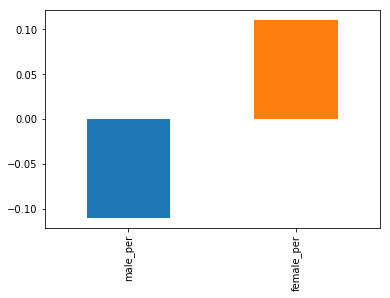

In [27]:
full.corr()["sat_score"][["male_per", "female_per"]].plot.bar()

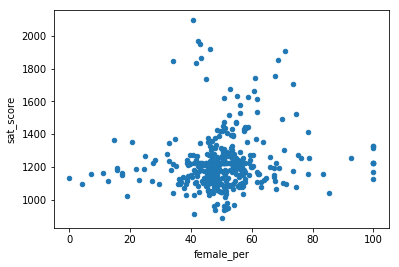

In [28]:
# To dig more into the correlation, we can make a scatterplot of female_per and sat_score:
full.plot.scatter(x='female_per', y='sat_score')

It looks like there's a cluster of schools with a high percentage of females, and very high SAT scores (in the top right). We can get the names of the schools in this cluster:

In [29]:
full[(full["female_per"] > 65) & (full["sat_score"] > 1400)]["School Name"]

3             PROFESSIONAL PERFORMING ARTS HIGH SCH
92                    ELEANOR ROOSEVELT HIGH SCHOOL
100                    TALENT UNLIMITED HIGH SCHOOL
111            FIORELLO H. LAGUARDIA HIGH SCHOOL OF
229                     TOWNSEND HARRIS HIGH SCHOOL
250    FRANK SINATRA SCHOOL OF THE ARTS HIGH SCHOOL
265                  BARD HIGH SCHOOL EARLY COLLEGE
Name: School Name, dtype: object

Searching Google reveals that these are elite schools that focus on the performing arts. These schools tend to have higher percentages of females, and higher SAT scores. This likely accounts for the correlation between higher female percentages and SAT scores, and the inverse correlation between higher male percentages and lower SAT scores

#### AP scores
So far, we've looked at demographic angles. One angle that we have the data to look at is the relationship between more students taking Advanced Placement exams and higher SAT scores. It makes sense that they would be correlated, since students who are high academic achievers tend to do better on the SAT.

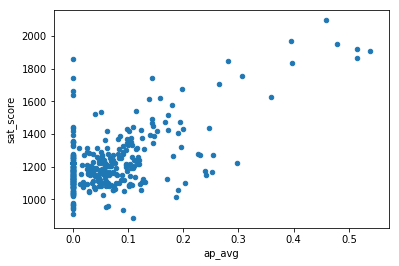

In [30]:
full["ap_avg"] = full["AP Test Takers "] / full["total_enrollment"]

full.plot.scatter(x='ap_avg', y='sat_score')

It looks like there is indeed a strong correlation between the two. An interesting cluster of schools is the one at the top right, which has high SAT scores and a high proportion of students that take the AP exams:

In [31]:
full[(full["ap_avg"] > .3) & (full["sat_score"] > 1700)]["School Name"]

92             ELEANOR ROOSEVELT HIGH SCHOOL
98                    STUYVESANT HIGH SCHOOL
157             BRONX HIGH SCHOOL OF SCIENCE
161    HIGH SCHOOL OF AMERICAN STUDIES AT LE
176           BROOKLYN TECHNICAL HIGH SCHOOL
229              TOWNSEND HARRIS HIGH SCHOOL
243    QUEENS HIGH SCHOOL FOR THE SCIENCES A
260      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

Some Google searching reveals that these are mostly highly selective schools where you need to take a test to get in. It makes sense that these schools would have high proportions of AP test takers.